<a href="https://colab.research.google.com/github/Prernatripathi7/24095082-CSOC-IG/blob/main/Seq2Seq/Part1%26Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.2 MB/s eta 0:00:00


In [4]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12

In [5]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 67.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [6]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contractions
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import spacy
import random
import math
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
spacy_en = spacy.load("en_core_web_sm")
spacy_de = spacy.load("de_core_news_sm")

In [10]:
from datasets import load_dataset
dataset = load_dataset("bentrevett/multi30k")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
def tokenize_en(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]
def tokenize_de(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]
def tokenize_function(examples):
    return {
        "SRC": [tokenize_en(example) for example in examples["en"]],
        "TRG": [tokenize_de(example) for example in examples["de"]],
    }
tokenized_dataset = dataset.map(tokenize_function, batched=True)
def build_vocab(tokenized_data, min_freq=2):
    vocab = {"<PAD>": 0, "<UNK>": 1, "<SOS>": 2, "<EOS>": 3}
    idx = 4
    token_counter = Counter(token for tokens in tokenized_data for token in tokens)
    for token, freq in token_counter.items():
        if freq >= min_freq and token not in vocab:
            vocab[token] = idx
            idx += 1
    return vocab
src_vocab = build_vocab(tokenized_dataset["train"]["SRC"])
trg_vocab = build_vocab(tokenized_dataset["train"]["TRG"])
def numericalize(tokens, vocab):
    return [vocab["<SOS>"]] + [vocab.get(token, vocab["<UNK>"]) for token in tokens] + [vocab["<EOS>"]]
def numericalize_function(examples):
    return {
        "SRC": [numericalize(tokens, src_vocab) for tokens in examples["SRC"]],
        "TRG": [numericalize(tokens, trg_vocab) for tokens in examples["TRG"]]
    }
numericalized_dataset = tokenized_dataset.map(numericalize_function, batched=True)
def collate_fn(batch):
    src = [torch.tensor(item["SRC"]) for item in batch]
    trg = [torch.tensor(item["TRG"]) for item in batch]
    src_padded = pad_sequence(src, batch_first=True, padding_value=src_vocab["<PAD>"])
    trg_padded = pad_sequence(trg, batch_first=True, padding_value=trg_vocab["<PAD>"])
    return src_padded, trg_padded
train_loader = DataLoader(numericalized_dataset["train"], batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(numericalized_dataset["validation"], batch_size=128, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(numericalized_dataset["test"], batch_size=128, shuffle=True, collate_fn=collate_fn)
pad_token = "<PAD>"
PAD_IDX = trg_vocab[pad_token]
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True,bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.device = device
    def forward(self, src):
      embedded = self.dropout(self.embedding(src))
      batch_size = src.shape[0]
      hidden = torch.zeros(self.n_layers * 2, batch_size, self.hid_dim).to(self.device)
      cell = torch.zeros(self.n_layers * 2, batch_size, self.hid_dim).to(self.device)
      outputs, (hidden, cell) = self.rnn(embedded, (hidden, cell))
      def combine_directions(state):
            return torch.cat((state[::2], state[1::2]), dim=2)
      hidden = combine_directions(hidden)
      cell = combine_directions(cell)
      return hidden, cell
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input, hidden, cell):
      input = input.unsqueeze(1)
      embedded = self.dropout(self.embedding(input))
      output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
      prediction = self.fc_out(output.squeeze(1))
      return prediction, hidden, cell
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (encoder.hid_dim*2 == decoder.hid_dim)
        assert (encoder.n_layers == decoder.n_layers)
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        return outputs
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
enc = Encoder(INPUT_DIM, 256, HID_DIM, N_LAYERS, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, 256, HID_DIM*2, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(enc, dec, device).to(device)
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
def train(model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for src, trg in dataloader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg,0)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    model.train()
    return epoch_loss / len(dataloader)
N_EPOCHS = 17
CLIP = 1
best_valid_loss = float("inf")
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "best-model.pt")
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}")
model.load_state_dict(torch.load("best-model.pt"))
test_loss = evaluate(model, test_loader, criterion)
print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f}")
inv_trg_vocab = {i: w for w, i in trg_vocab.items()}
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()
    tokens = [tok.text for tok in spacy_en.tokenizer(sentence)][::-1]
    numericalized = (
        [src_vocab["<SOS>"]]
        + [src_vocab.get(token, src_vocab["<UNK>"]) for token in tokens]
        + [src_vocab["<EOS>"]]
    )
    src_tensor = torch.LongTensor(numericalized).unsqueeze(0).to(device)
    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)
    trg_indexes = [trg_vocab["<SOS>"]]
    for _ in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == trg_vocab["<EOS>"]:
            break
    inv_trg_vocab = {idx: token for token, idx in trg_vocab.items()}
    translated_tokens = [inv_trg_vocab[idx] for idx in trg_indexes]
    return translated_tokens[1:-1]
test_examples = dataset["test"]
predicted_translations = []
reference_translations = []
for sentence, reference in zip(test_examples["en"], test_examples["de"]):
    pred = translate_sentence(sentence, src_vocab, trg_vocab, model, device)
    ref = [tok.text for tok in spacy_de.tokenizer(reference)]
    predicted_translations.append(pred)
    reference_translations.append([ref])
bleu_score = corpus_bleu(reference_translations, predicted_translations)
print("Corpus BLEU score:", bleu_score)

Using device: cuda
Epoch: 01
	Train Loss: 5.041 | Train PPL: 154.569
	 Val. Loss: 4.859 |  Val. PPL: 128.875
Epoch: 02
	Train Loss: 4.289 | Train PPL:  72.910
	 Val. Loss: 4.603 |  Val. PPL:  99.772
Epoch: 03
	Train Loss: 3.947 | Train PPL:  51.775
	 Val. Loss: 4.380 |  Val. PPL:  79.866
Epoch: 04
	Train Loss: 3.659 | Train PPL:  38.823
	 Val. Loss: 4.228 |  Val. PPL:  68.558
Epoch: 05
	Train Loss: 3.401 | Train PPL:  30.006
	 Val. Loss: 4.086 |  Val. PPL:  59.484
Epoch: 06
	Train Loss: 3.150 | Train PPL:  23.335
	 Val. Loss: 3.954 |  Val. PPL:  52.163
Epoch: 07
	Train Loss: 2.932 | Train PPL:  18.766
	 Val. Loss: 3.843 |  Val. PPL:  46.678
Epoch: 08
	Train Loss: 2.734 | Train PPL:  15.392
	 Val. Loss: 3.815 |  Val. PPL:  45.369
Epoch: 09
	Train Loss: 2.551 | Train PPL:  12.818
	 Val. Loss: 3.769 |  Val. PPL:  43.331
Epoch: 10
	Train Loss: 2.389 | Train PPL:  10.899
	 Val. Loss: 3.757 |  Val. PPL:  42.839
Epoch: 11
	Train Loss: 2.219 | Train PPL:   9.200
	 Val. Loss: 3.732 |  Val. PPL:

Epoch: 01
	Train Loss: 4.686 | Train PPL: 108.455
	 Val. Loss: 4.126 |  Val. PPL:  61.900
Epoch: 02
	Train Loss: 3.451 | Train PPL:  31.524
	 Val. Loss: 3.684 |  Val. PPL:  39.787
Epoch: 03
	Train Loss: 2.942 | Train PPL:  18.953
	 Val. Loss: 3.515 |  Val. PPL:  33.620
Epoch: 04
	Train Loss: 2.608 | Train PPL:  13.569
	 Val. Loss: 3.383 |  Val. PPL:  29.447
Epoch: 05
	Train Loss: 2.350 | Train PPL:  10.481
	 Val. Loss: 3.380 |  Val. PPL:  29.366
Epoch: 06
	Train Loss: 2.140 | Train PPL:   8.496
	 Val. Loss: 3.294 |  Val. PPL:  26.943
Epoch: 07
	Train Loss: 1.933 | Train PPL:   6.914
	 Val. Loss: 3.393 |  Val. PPL:  29.753
Epoch: 08
	Train Loss: 1.784 | Train PPL:   5.954
	 Val. Loss: 3.391 |  Val. PPL:  29.694
Epoch: 09
	Train Loss: 1.630 | Train PPL:   5.101
	 Val. Loss: 3.443 |  Val. PPL:  31.275
Epoch: 10
	Train Loss: 1.554 | Train PPL:   4.729
	 Val. Loss: 3.460 |  Val. PPL:  31.819
Epoch: 11
	Train Loss: 1.437 | Train PPL:   4.209
	 Val. Loss: 3.512 |  Val. PPL:  33.508
Epoch: 12


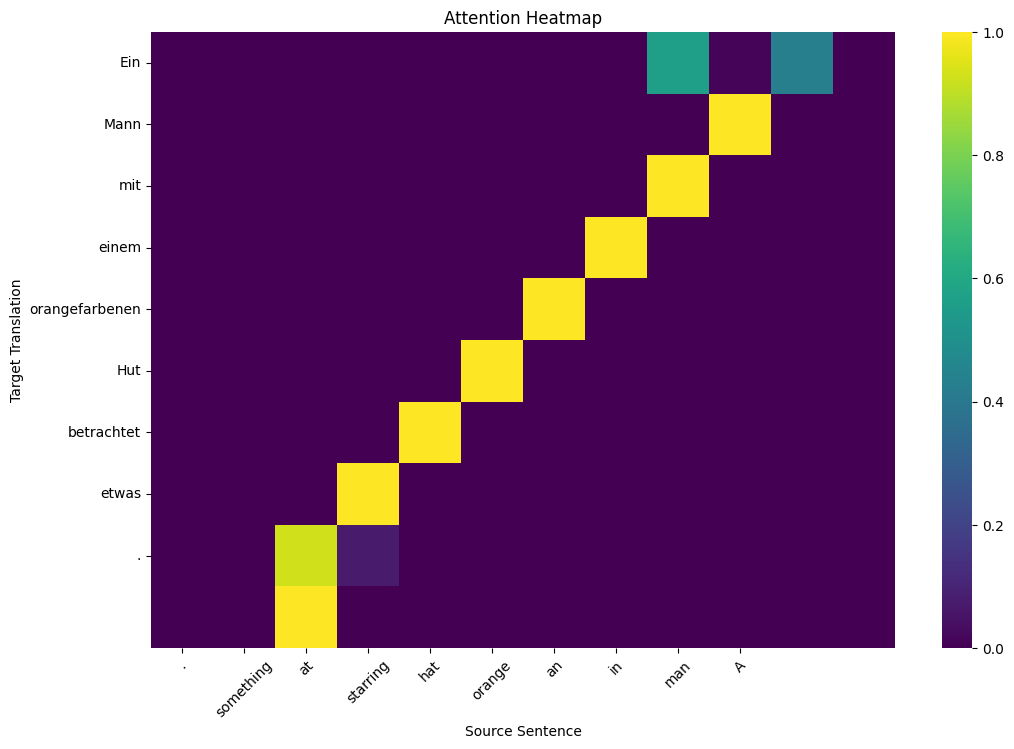

Source:     A Boston Terrier is running on lush green grass in front of a white fence.
Reference:  Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.
Prediction: Ein <UNK> - Fahrer rennt mit einem grünen Gras vor einem weißen Zaun .



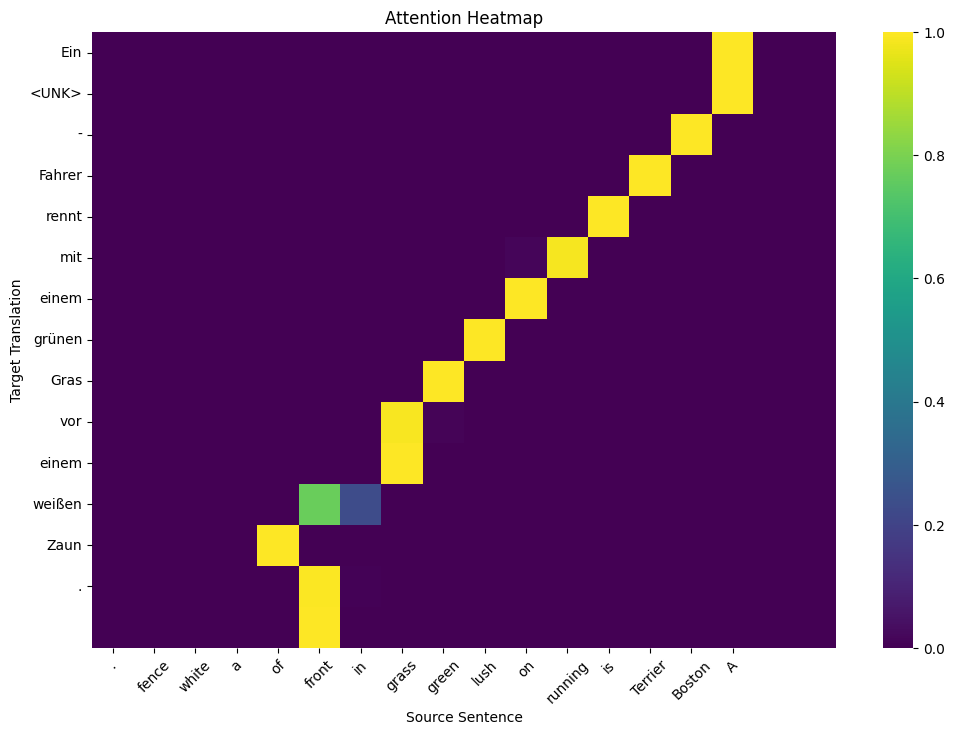

Source:     A girl in karate uniform breaking a stick with a front kick.
Reference:  Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.
Prediction: Ein Mädchen in einem Kleidung mit einem Stock mit einem <UNK> .



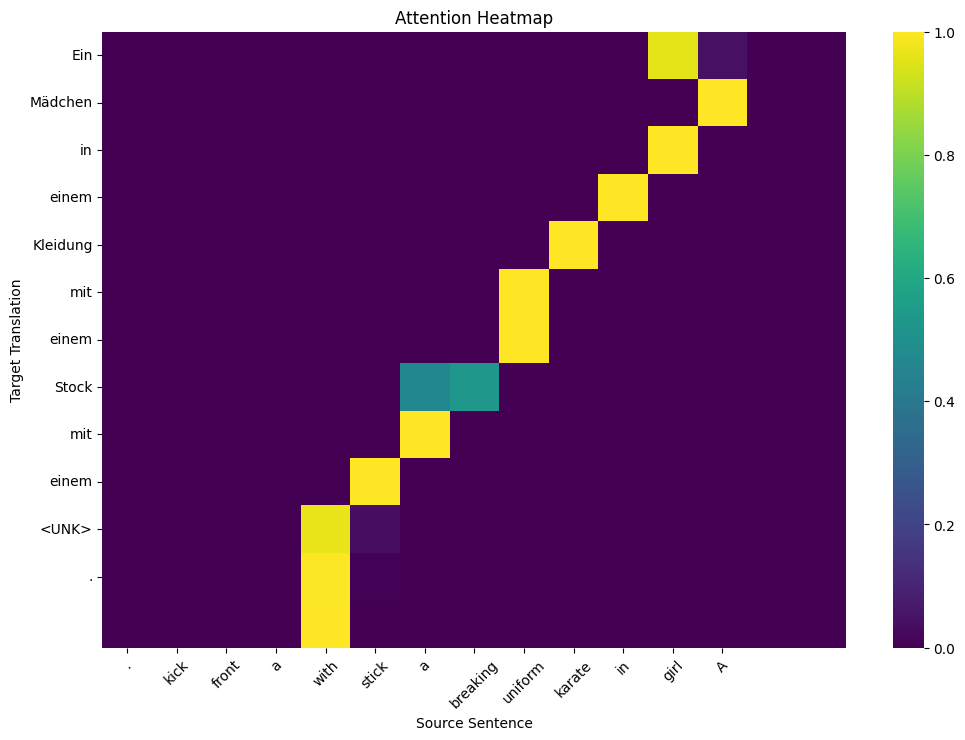

In [12]:
class LuongAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
    def forward(self, decoder_hidden, encoder_outputs, mask=None):
        decoder_hidden = self.attn(decoder_hidden).unsqueeze(1)
        energy = torch.bmm(decoder_hidden, encoder_outputs.transpose(1, 2))
        if mask is not None:
              energy = energy.masked_fill(mask.unsqueeze(1) == 0, float('-inf'))
        attn_weights = torch.softmax(energy, dim=2)
        context = torch.bmm(attn_weights, encoder_outputs)
        return context.squeeze(1), attn_weights.squeeze(1)
class Decoder1(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = dec_hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_IDX)
        self.attention = attention
        self.rnn = nn.LSTM(enc_hid_dim + emb_dim, dec_hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(dec_hid_dim + enc_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input, hidden, cell, encoder_outputs,mask):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        last_hidden = hidden[-1]
        context, attn_weights = self.attention(last_hidden, encoder_outputs,mask)
        context = context.unsqueeze(1)
        rnn_input = torch.cat((embedded, context), dim=2)
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        output = output.squeeze(1)
        embedded = embedded.squeeze(1)
        context = context.squeeze(1)
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))
        return prediction, hidden, cell, attn_weights
class Seq2Seq1(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert encoder.hid_dim * 2 == decoder.attention.attn.in_features
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs, hidden, cell = self.encoder(src)
        input = trg[:, 0]
        mask = (src != PAD_IDX)
        for t in range(1, trg_len):
            output, hidden, cell, _ = self.decoder(input, hidden, cell, encoder_outputs, mask)
            outputs[:, t, :] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        return outputs
class Encoder1(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_IDX)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True,bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.device = device
    def forward(self, src):
      embedded = self.dropout(self.embedding(src))
      batch_size = src.shape[0]
      hidden = torch.zeros(self.n_layers * 2, batch_size, self.hid_dim).to(self.device)
      cell = torch.zeros(self.n_layers * 2, batch_size, self.hid_dim).to(self.device)
      outputs, (hidden, cell) = self.rnn(embedded, (hidden, cell))
      def combine_directions(state):
            return torch.cat((state[::2], state[1::2]), dim=2)
      hidden = combine_directions(hidden)
      cell = combine_directions(cell)
      return outputs, hidden, cell
enc1 = Encoder1(INPUT_DIM, 256, HID_DIM, N_LAYERS, ENC_DROPOUT, device)
attn = LuongAttention(HID_DIM * 2)
dec1 = Decoder1(OUTPUT_DIM, 256, HID_DIM * 2, HID_DIM * 2, N_LAYERS, DEC_DROPOUT, attn)
model1 = Seq2Seq1(enc1, dec1, device).to(device)
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
model1.apply(init_weights)
optimizer = optim.Adam(model1.parameters())
def train(model, dataloader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for src, trg in dataloader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg,0)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    model.train()
    return epoch_loss / len(dataloader)
N_EPOCHS = 15
CLIP = 1
best_valid_loss = float("inf")
for epoch in range(N_EPOCHS):
    train_loss = train(model1, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model1, val_loader, criterion)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model1.state_dict(), "best-model1.pt")
    print(f"Epoch: {epoch+1:02}")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}")
model1.load_state_dict(torch.load("best-model1.pt"))
test_loss = evaluate(model1, test_loader, criterion)
print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f}")
inv_trg_vocab = {i: w for w, i in trg_vocab.items()}
def translate_with_attention(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()
    tokens = [tok.text for tok in spacy_en.tokenizer(sentence)][::-1]
    numericalized = (
        [src_vocab["<SOS>"]] +
        [src_vocab.get(token, src_vocab["<UNK>"]) for token in tokens] +
        [src_vocab["<EOS>"]]
    )
    src_tensor = torch.LongTensor(numericalized).unsqueeze(0).to(device)
    mask = (src_tensor != PAD_IDX)
    with torch.no_grad():
        encoder_outputs, hidden, cell = model.encoder(src_tensor)
    trg_indexes = [trg_vocab["<SOS>"]]
    attentions = []
    for _ in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, cell, attn_weights = model.decoder(
                trg_tensor, hidden, cell, encoder_outputs, mask)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        attentions.append(attn_weights.squeeze(0).cpu().numpy())
        if pred_token == trg_vocab["<EOS>"]:
            break
    inv_trg_vocab = {idx: token for token, idx in trg_vocab.items()}
    translated_tokens = [inv_trg_vocab[idx] for idx in trg_indexes]
    return translated_tokens[1:-1], tokens, attentions
test_examples = dataset["test"]
predicted_translations = []
reference_translations = []
for sentence, reference in zip(test_examples["en"], test_examples["de"]):
    pred_tokens, _, _ = translate_with_attention(sentence, src_vocab, trg_vocab, model1, device)
    ref_tokens = [tok.text for tok in spacy_de.tokenizer(reference)]
    predicted_translations.append(pred_tokens)
    reference_translations.append([ref_tokens])
bleu_score = corpus_bleu(reference_translations, predicted_translations)
print("Corpus BLEU score:", bleu_score)
import matplotlib.pyplot as plt
import seaborn as sns
def plot_attention(src_tokens, trg_tokens, attentions):
    fig, ax = plt.subplots(figsize=(12, 8))
    attention_matrix = np.stack(attentions)  # [tgt_len, src_len]
    sns.heatmap(attention_matrix, xticklabels=src_tokens, yticklabels=trg_tokens,
                cmap="viridis", cbar=True, ax=ax)
    ax.set_xlabel("Source Sentence")
    ax.set_ylabel("Target Translation")
    plt.xticks(rotation=45)
    plt.title("Attention Heatmap")
    plt.show()
for i in range(3):
    src_sentence = dataset["test"]["en"][i]
    tgt_sentence = dataset["test"]["de"][i]
    translated, src_tokens, attn_weights = translate_with_attention(
        src_sentence, src_vocab, trg_vocab, model1, device
    )
    print(f"Source:     {src_sentence}")
    print(f"Reference:  {tgt_sentence}")
    print(f"Prediction: {' '.join(translated)}\n")
    plot_attention(src_tokens, translated, attn_weights)